# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>Helpers utilities</b> 

<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

This file is the helpers file for the other notebooks. It is not meant to be run as a self-sufficient notebook, but will be called by functions from the other notebooks using the **import** feature of python. It is however encouraged to check this file whenever one of these functions is used in another notebook, since it provides documentation and context for each of the code snippets presented here. 

In [3]:
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
from scipy import signal
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib

figsize=(10,5)

# 1. Plotting utilities

## 1.1 Transfer function into pole-zero plot

The zplane function was coded by Christopher Felton and plots a pole-zero plot given the the coefficients of the z-transform of a filter. It also returns the coordinates of each pole and zero as an array.

In [22]:
# Copyright (c) 2011 Christopher Felton
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#

# The following is derived from the slides presented by
# Alexander Kain for CS506/606 "Special Topics: Speech Signal Processing"
# CSLU / OHSU, Spring Term 2011.
    
def zplane(b,a,filename=None):
    """Plot the complex z-plane given a transfer function.
    """

    # get a figure/plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='g')

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
    
    return z, p, k

Let's try the function with a simple IIR filter.

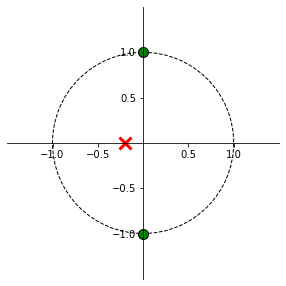

In [23]:
if __name__ == '__main__':
    b = np.array((1, 0 , 1)) # Zeros
    a = np.array((.5, .1)) # Poles

    zplane(b,a)

## 1.2 Transfer function into frequency response plot

Similarly, the freq_response function plots the frequency response of a filter given the coefficients of the transfer function.

In [14]:
def freq_response(b, a, half=False):
    w, h = signal.freqz(b, a, whole=True)
    fig, ax1 = plt.subplots(figsize = figsize)

    ax1.plot(w, abs(h), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g', alpha=.3)
    ax2.set_ylabel('Phase (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    if half==True:
        plt.xlim(0, np.pi)
    plt.show()

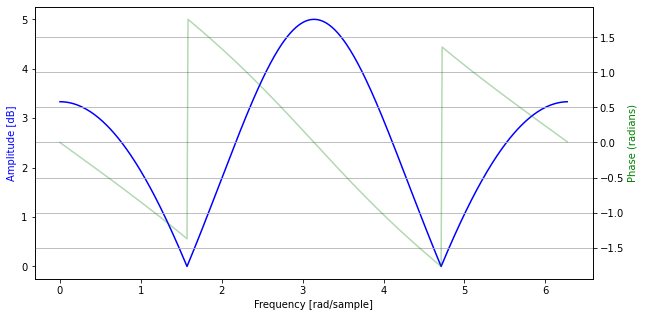

In [15]:
if __name__ == '__main__':
    freq_response(b,a)

# 2. Filtering utilities

This section contains functions for filtering signals. They always take a signal (a numpy array) as a parameter called **x** and return the filtered signal (also a numpy array) of the same size.

## 2.1 Moving average

This function is a simple moving average, used to smooth out a signal. It can be used to compute a signal's envelope, or simply as a lowpass filter.

In [6]:
# Moving average
def moving_average(x, N=10):
    '''
    Helper function to compute the smoothed sequence x using a moving average of size N.
    x: the input signal
    N: the integer size of the moving average
    '''
    augmented_x = np.concatenate((tuple([x[0] for i in range(int(N/2))]) , x , tuple([x[-1] for i in range(int(N/2)-1)])))
    res = np.convolve(augmented_x, np.ones((N,))/N, mode='valid')
    return res

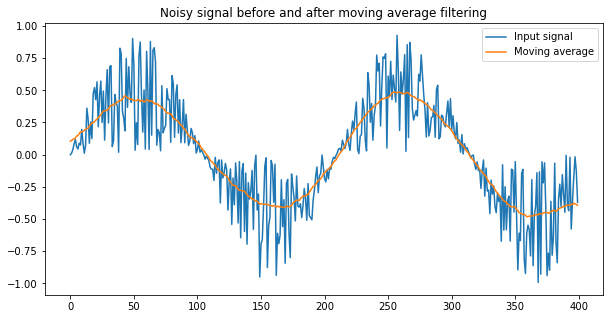

In [7]:
if __name__ == '__main__':
    input_signal = np.array([np.sin(0.03*x) * np.random.random() for x in range(0, 400)])
    output_signal = moving_average(input_signal, N=50)

    plt.figure(figsize=figsize)
    plt.plot(input_signal, label="Input signal")
    plt.plot(output_signal, label="Moving average")
    plt.title("Noisy signal before and after moving average filtering")
    plt.legend()
    plt.show()

## 2.2 Butterworth filter

This next function implements a Butterworth filter.

In [8]:
def butter_pass_filter(x, lowhighcut, fs, btype, order=5):
    """
    Butterpass filter.
    x: input signal
    lowhighcut: numpy array of the cutoff frequency.ies (1 freq is lowpass or highpass, 2 freqs if bandpass)
    fs: sampling frequency
    btype: type of the filter, "low", "high" or "band"
    order: the order of the Butterworth filter
    """
    def butter_pass(lowhighcut, fs, btype, order=5):
        nyq = 0.5 * fs
        lowhigh =  lowhighcut / nyq
        sos = butter(order, lowhigh, analog=False, btype=btype, output='sos')
        return sos
    
    sos = butter_pass(lowhighcut, fs, btype, order=order)
    y = sosfilt(sos, x)
    return y

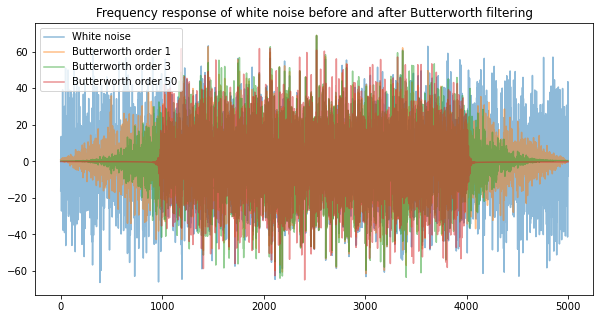

In [9]:
if __name__ == '__main__':
    input_signal = np.random.random(10000)

    alpha=.5

    plt.figure(figsize=figsize)
    plt.plot(np.real(fft(input_signal))[1:int(input_signal.size/2)], alpha=alpha, label="White noise")
    output_signal = butter_pass_filter(input_signal, np.array([1000,4000]), 10000, "band", order=1)
    plt.plot(np.real(fft(output_signal))[1:int(input_signal.size/2)], alpha=alpha, label="Butterworth order 1")
    output_signal = butter_pass_filter(input_signal, np.array([1000,4000]), 10000, "band", order=3)
    plt.plot(np.real(fft(output_signal))[1:int(input_signal.size/2)], alpha=alpha, label="Butterworth order 3")
    output_signal = butter_pass_filter(input_signal, np.array([1000,4000]), 10000, "band", order=50)
    plt.plot(np.real(fft(output_signal))[1:int(input_signal.size/2)], alpha=alpha, label="Butterworth order 50")
    plt.title("Frequency response of white noise before and after Butterworth filtering")
    plt.legend()
    plt.show()

## 2.3 Linear predictive coding

Here are helper functions for generating a chosen number of LPC coefficients of an audio signal.

In [18]:
def bac(x, p):
    # By Paolo Prandoni
    # compute the biased autocorrelation for x up to lag p
    L = len(x)
    r = np.zeros(p+1)
    for m in range(0, p+1):
        for n in range(0, L-m):
            r[m] += x[n] * x[n+m]
        r[m] /= float(L)
    return r

In [19]:
def ld(r, p):
    # By Paolo Prandoni
    # solve the toeplitz system using the Levinson-Durbin algorithm
    g = r[1] / r[0]
    a = np.array([g])
    v = (1. - g * g) * r[0];
    for i in range(1, p):
        g = (r[i+1] - np.dot(a, r[1:i+1])) / v
        a = np.r_[ g,  a - g * a[i-1::-1] ]
        v *= 1. - g*g
    # return the coefficients of the A(z) filter
    return np.r_[1, -a[::-1]]

In [20]:
def lpc(x, p):
    # By Paolo Prandoni
    """
    Computes p LPC coefficients for a speech segment
    x: the input signal
    p: the integer number of LPC coefficients
    return: array containg the coefficients
    """
    return ld(bac(x, p), p)

We can try the LPC prediction on a test signal.

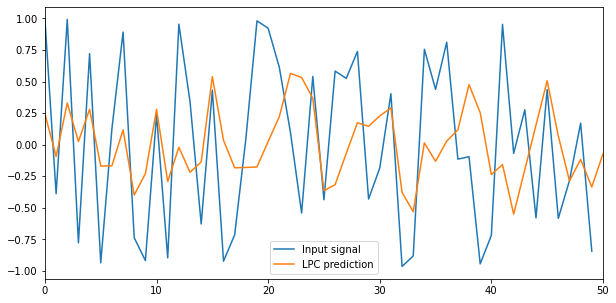

In [74]:
if __name__ == '__main__':
    size = 50
    input_signal = np.random.uniform(low=-1, high=1, size=size)
    
    lpc_coef = lpc(input_signal, 11)
    conv = np.convolve(input_signal, lpc_coef[1:])
    
    plt.figure(figsize=figsize)
    plt.plot(input_signal, label="Input signal")
    plt.plot(conv, label="LPC prediction")
    plt.legend()
    plt.xlim(0, size)
    plt.show()

# 3. Other

## 3.1 Resampling functions

The next 2 functions are used to oversample, respectively undersample a signal. 

In [10]:
def oversample(x, oversampling_rate=8):
    return signal.resample(x, x.size*oversampling_rate)

def undersample(x, oversampling_rate=8):
    return signal.resample(x, int(x.size / oversampling_rate))

We can try to plot a signal, its undersampled version, and then we oversample it back ot the original number of samples. We remark that as long as we stay below the niquist frequency, the reconstructed signal is similar to the original one:

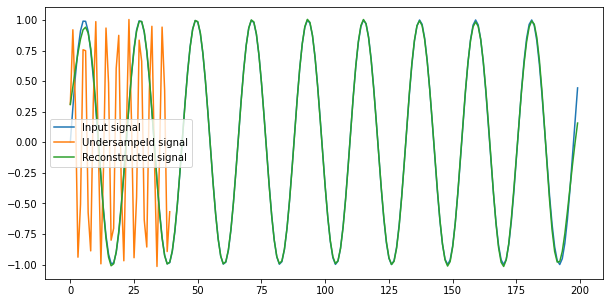

In [11]:
if __name__ == '__main__':
    input_signal = np.array([np.sin(0.9/np.pi*x) for x in range(0,200)])

    resamp = 5
    under_signal = undersample(input_signal, resamp)
    over_signal = oversample(under_signal, resamp)

    plt.figure(figsize=figsize)
    plt.plot(input_signal, label="Input signal")
    plt.plot(under_signal, label="Undersampeld signal")
    plt.plot(over_signal, label="Reconstructed signal")
    plt.legend()
    plt.show()

Of course, if we exceed the nyquist frequency, the reconstructed signal is distorted.

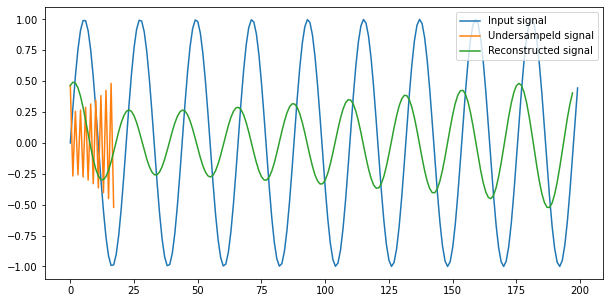

In [12]:
if __name__ == '__main__':
    resamp = 11
    under_signal = undersample(input_signal, resamp)
    over_signal = oversample(under_signal, resamp)

    plt.figure(figsize=figsize)
    plt.plot(input_signal, label="Input signal")
    plt.plot(under_signal, label="Undersampeld signal")
    plt.plot(over_signal, label="Reconstructed signal")
    plt.legend()
    plt.show()

## 3.2 Read and write utilities

This is a function to open an audio file on the computer as a Numpy array. It also displays the file.

**TODO: add stereo to mono when needed and compatiblity with all input bit depth**

In [ ]:
def open_audio(path):
    """
    Open an audio .wav file as a numpy array, plot it and play it.
    path: the file path of the audio file
    return: a numpy array containing the audio data in (-1, 1)
    """
    fs, data = wavfile.read(path)
    data = np.array(data, dtype=np.float32)
    data /= np.max(np.abs(data) ) # Normalize
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.show()
    return data

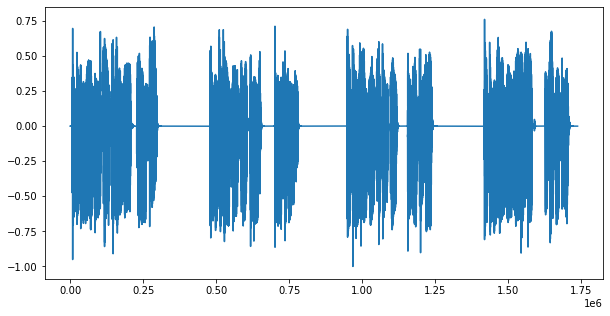

In [14]:
if __name__ == '__main__':
    open_audio('samples/nightcall_modulator.wav')

The complentary function takes a numpy array and writes it on the computer as a .wav file.

In [ ]:
def write_audio(x, path, fs=44100):
    """
    Write numpy array 'x' as an audio .wav file at the given path. Subsequently generates a widget for playing this file.
    x: the input audio data
    path: the file path where to write the write file
    fs: the sampling rate
    return: the widget for listening to this audio file
    """
    x /= np.max(np.abs(x) ) # Normalize
    wavfile.write(path, fs, (0x7FFF * x).astype(np.int16))
    return Audio(path, rate=fs, autoplay=False)